# 1. Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# 2. Importing Kaggle Dataset

In [2]:
!pip install kaggle

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 96% 332M/346M [00:02<00:00, 153MB/s]
100% 346M/346M [00:02<00:00, 160MB/s]


In [5]:
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

# 3. Loading Data

In [6]:
train_dir = '/content/seg_train/seg_train'
val_dir = '/content/seg_test/seg_test'
test_dir = '/content/seg_pred/seg_pred'

## 3.1 Scaling Data

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [8]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'
)
val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# 4. Visualizing Data

## 4.1 Training data

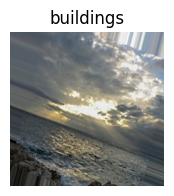

In [23]:
images, labels = next(train_data)
class_names = {v: k for k, v in train_data.class_indices.items()}

plt.figure(figsize=(2, 2))
plt.imshow(images[1])
label_index = np.argmax(labels[1])
label_name = class_names[label_index]
plt.title(f"{label_name}")
plt.axis('off')

plt.show()


## 4.2 Labels Integer Based

In [10]:
train_data[0][1]

array([2., 0., 5., 4., 2., 3., 5., 4., 4., 2., 4., 3., 3., 4., 5., 5., 0.,
       2., 1., 1., 0., 1., 2., 1., 2., 2., 0., 2., 1., 2., 2., 4.],
      dtype=float32)

# 5. CNN Model Building

## 5.1 Architecture

In [11]:
model = tf.keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape = (256,256,3)),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),

    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(6, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      58,982,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,079,238 (225.37 MB)

 Trainable params: 59,079,238 (225.37 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


## 5.2 Model Training

In [14]:
model.fit(train_data, epochs = 20, validation_data = val_data, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 244s 533ms/step - accuracy: 0.4817 - loss: 1.4961 - val_accuracy: 0.6843 - val_loss: 0.8755
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 221s 504ms/step - accuracy: 0.6481 - loss: 0.9178 - val_accuracy: 0.7290 - val_loss: 0.7520
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 218s 497ms/step - accuracy: 0.6999 - loss: 0.8124 - val_accuracy: 0.7427 - val_loss: 0.6901
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 221s 503ms/step - accuracy: 0.7150 - loss: 0.7568 - val_accuracy: 0.7097 - val_loss: 0.8377
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 218s 496ms/step - accuracy: 0.7413 - loss: 0.7096 - val_accuracy: 0.7687 - val_loss: 0.6626
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 217s 493ms/step - accuracy: 0.7558 - loss: 0.6601 - val_accuracy: 0.8177 - val_loss: 0.5147
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 216s 492ms/step - accuracy: 0.7770 - loss: 0.6022 - val_accuracy: 0.8323 - val_loss: 0.4834
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 218s 497ms/step - accuracy: 0.7796 -

### However, the accuracy can be further increased if we train our model for more epochs. The accuracy will continue to improve, and the loss will decrease, without the fear of overfitting

# 6. Model Testing

# 6.1 Testing On Unseen Data

In [34]:
img_path = '/content/seg_pred/seg_pred/10004.jpg'

In [56]:
from tensorflow.keras.preprocessing import image
import numpy as np
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)


img_array = img_array / 256.0

print(img_array.shape)


(256, 256, 3)


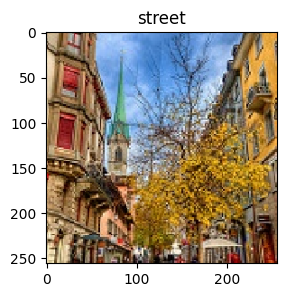

In [57]:
plt.figure(figsize=(3,3))
plt.imshow(img_array)
plt.title('street')
plt.show()

In [50]:
class_names = {
    'building': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4,
    'street': 5,
}

In [48]:
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step


In [54]:
predicted_class_index = np.argmax(prediction)

In [59]:
for class_name, index in class_names.items():
    if index == predicted_class_index:
        predicted_class_label = class_name
        break
print(predicted_class_label)

street


## 6.2 Accuracy Comparision

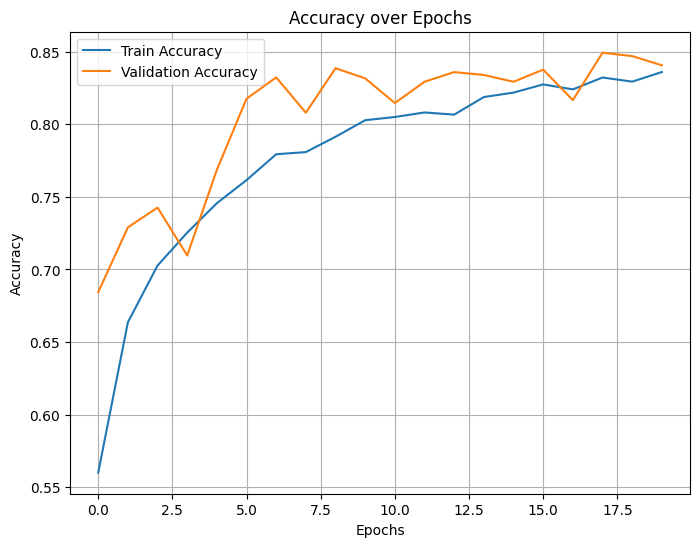

In [15]:
import matplotlib.pyplot as plt

history = model.history.history

plt.figure(figsize=(8, 6))
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## 6.3 Loss Comaprision

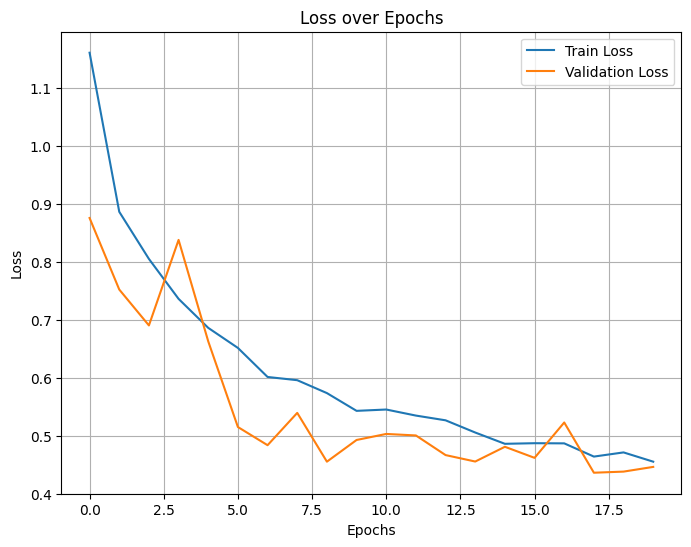

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## 7. Model Export

In [17]:
model.save('/content/my_model.h5')

In [18]:
from google.colab import files
files.download('/content/my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>